In [1]:
import pandas as pd
import numpy as np

import bs4
from bs4 import BeautifulSoup
import requests


import re
import unicodedata

In [2]:
url = "https://www.debates.org/voter-education/debate-transcripts"

In [3]:
response = requests.get(url)
soup = BeautifulSoup(response.content)
a = soup.find_all("a", href = True) 

In [4]:
debates= [{a.text:a["href"]} for a in a]

In [5]:
soup_list = list(a)

type(soup_list[0].text)

soup_list = [item for item in soup_list if 'Transcript' in item.text]

In [6]:
soup_list = soup_list[1:-2]

In [7]:
soup_list[0]

<a href="/voter-education/debate-transcripts/vice-presidential-debate-at-the-university-of-utah-in-salt-lake-city-utah/">October 07, 2020 Vice Presidential Debate Transcript</a>

In [8]:
href_list = ["https://www.debates.org/"+item.get('href') for item in soup_list]

In [9]:
href_list

['https://www.debates.org//voter-education/debate-transcripts/vice-presidential-debate-at-the-university-of-utah-in-salt-lake-city-utah/',
 'https://www.debates.org//voter-education/debate-transcripts/october-22-2020-debate-transcript/',
 'https://www.debates.org//voter-education/debate-transcripts/september-29-2020-debate-transcript/',
 'https://www.debates.org//voter-education/debate-transcripts/october-19-2016-debate-transcript/',
 'https://www.debates.org//voter-education/debate-transcripts/october-9-2016-debate-transcript/',
 'https://www.debates.org//voter-education/debate-transcripts/october-4-2016-debate-transcript/',
 'https://www.debates.org//voter-education/debate-transcripts/september-26-2016-debate-transcript/',
 'https://www.debates.org//voter-education/debate-transcripts/october-22-2012-the-third-obama-romney-presidential-debate/',
 'https://www.debates.org//voter-education/debate-transcripts/october-16-2012-the-second-obama-romney-presidential-debate/',
 'https://www.de

In [10]:
debate_dicts = {}
for i in href_list:
    response = requests.get(i)
    soup = BeautifulSoup(response.content)
    p = soup.find_all("p") 
    debate_dicts[i] = p

------
# Text Cleaner

In [11]:
def clean_text(text):
    new_text = re.sub('<[^>]+>', '', text)  #Removes HTML tags
    return unicodedata.normalize("NFKD", new_text) #Returns the normal form from the Unicode string

In [12]:
def split_text(text):
    split_text = text.split(":") #splits every element in list at " : "
    return [(line).rsplit(' ', 1) for line in split_text] #seperates the last word from every element in list to get speaker name

In [13]:
def flatten(text):
    return [item for sublist in text for item in sublist] #turns a list of lists into a list 

In [14]:
def to_df(text): #makes a dataframe with speaker in first column and text in the second column
    if len(text[33].split()) == 1 : #makes sure speaker index is even. Randomly chose 15
        text.pop(0) #removes first element in list
    if len(text)%2 == 1: #makes sure list is even
        text.pop() #removes last element in list
    return pd.DataFrame(np.array(text).reshape(len(text)//2,2), columns = ["Speaker", "Text"]) #makes a dataframe with 2 columns and (len(list)/2) rows

In [15]:
def format_df(df):
    new_df = pd.DataFrame(columns = ["Speaker", "Text"]) #creates new df 
    for i in df.index:
        if df["Speaker"].iloc[i] != (df["Speaker"].iloc[i]).upper(): #speakers are in ALLCAPS , so this finds words that aren't all capitalized
            if (i != 0): #to prevent errors
                text = df["Text"].iloc[i-1]  + " " + df["Speaker"].iloc[i] + df["Text"].iloc[i] # connects text from previous line and cuurent line
                new_df.at[new_df.index[-1], 'Text'] = text # replaces text from previous line 
        else :
            new_df = new_df.append(df.iloc[[i]])  #no problems with these lines so we append as is
    return new_df #returns new dataframe

In [16]:
debate_df = pd.DataFrame(columns=["Speaker", "Text", "Placeholder"]) 
final_debate_df = pd.DataFrame(columns=["Speaker", "Text", "Placeholder"])
for i in range(len(debate_dicts)):
    debate_text = str(list(debate_dicts.values())[i])   
    debate_text = clean_text(debate_text)
    debate_text = split_text(debate_text)
    debate_text = flatten(debate_text)
    temp_df = to_df(debate_text) #some word make its way to the speaker column if it had a colon after it
    temp_df["Placeholder"] = i #replace with election year(?)
    debate_df = pd.concat([debate_df, temp_df],ignore_index=True)

final_debate_df = format_df(debate_df) # removes nonspeakers from Speaker column
final_debate_df

,Speaker,Text,Placeholder
0,PARTICIPANTS,\nSenator Kamala Harris (D-CA) and\nVice Presi...,0
1,MODERATOR,"\nSusan Page (USA Today),",0
2,PAGE,Good evening. From the University of Utah in ...,0
3,PENCE,"Thank you.,",0
4,PAGE,Senator Harris and Vice President Pence thank...,0
...,...,...,...
9498,SM1TH,Three minutes and twenty seconds for each can...,46
9499,NIXON,"Thank you, Mr. Smith. Senator Kennedy. First ...",46
9501,SMITH,"Senator Kennedy, your conclusion., MR.",46
9502,KENNEDY,as they look at this country and as they look...,46


In [17]:
import matplotlib.pyplot as plt

In [18]:
(final_debate_df['Speaker'].str.lower()== final_debate_df['Speaker']).value_counts()

False    9036
True       15
Name: Speaker, dtype: int64

In [19]:
final_debate_df[final_debate_df['Speaker'].str.lower()== final_debate_df['Speaker']]

,Speaker,Text,Placeholder
1468,9,00 PM Eastern that night. We hope you watch. U...,2
4282,9,"00 p.m. Eastern time, the two vice presidentia...",11
4481,9,"00 p.m. Eastern time, the two vice presidentia...",11
6305,9,"30 in the morning. Look, this is a funding cri...",22
6703,,"Well, I believe that we did the appropriate t...",25
6990,8,"30 to 9, Friday night on NBC from 8 to",26
6991,8,"30, and Saturday night on CBS from 8 to",26
6992,8,"30, we’ll be down in the trenches under the ho...",26
7016,10,"30 to 11 Eastern, we’re going to talk about ho...",27
7246,10,30 to,28


In [20]:
final_debate_df[final_debate_df['Speaker']=='SMITH']

,Speaker,Text,Placeholder
6481,SMITH,Good evening. I’m Michael Smith. I’m an elect...,23
8673,SMITH,"Mr. Stone, do you have a follow-up question f...",38
8677,SMITH,The same question now goes to President Carte...,38
8680,SMITH,"Mr. Stone, do you have a follow-up for?, MR.",38
8683,SMITH,"Governor Reagan, you have a minute to comment...",38
...,...,...,...
9491,SMITH,Mr. Vanocur’s question for Vice President Nix...,46
9494,SMITH,"Senator Kennedy., MR.",46
9496,SMITH,Can I have the summation time please? We’ve c...,46
9501,SMITH,"Senator Kennedy, your conclusion., MR.",46


In [21]:
for i in range(1,13):
    print(i)
    print(final_debate_df[final_debate_df['Speaker']==f'{i}']) #explains 12 data points
    print('\n')

1
Empty DataFrame
Columns: [Speaker, Text, Placeholder]
Index: []


2
Empty DataFrame
Columns: [Speaker, Text, Placeholder]
Index: []


3
Empty DataFrame
Columns: [Speaker, Text, Placeholder]
Index: []


4
Empty DataFrame
Columns: [Speaker, Text, Placeholder]
Index: []


5
Empty DataFrame
Columns: [Speaker, Text, Placeholder]
Index: []


6
Empty DataFrame
Columns: [Speaker, Text, Placeholder]
Index: []


7
     Speaker                                               Text Placeholder
8391       7  01 p.m. in the Music Hall at the Kansas City C...          35


8
     Speaker                                               Text Placeholder
6990       8             30 to 9, Friday night on NBC from 8 to          26
6991       8            30, and Saturday night on CBS from 8 to          26
6992       8  30, we’ll be down in the trenches under the ho...          26


9
     Speaker                                               Text Placeholder
1468       9  00 PM Eastern that night. We hope yo

<BarContainer object of 187 artists>

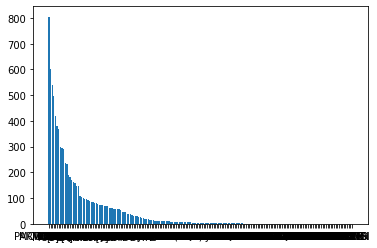

In [22]:
plt.bar(x=final_debate_df['Speaker'].unique(),height=final_debate_df['Speaker'].value_counts())

In [23]:
final_debate_df

,Speaker,Text,Placeholder
0,PARTICIPANTS,\nSenator Kamala Harris (D-CA) and\nVice Presi...,0
1,MODERATOR,"\nSusan Page (USA Today),",0
2,PAGE,Good evening. From the University of Utah in ...,0
3,PENCE,"Thank you.,",0
4,PAGE,Senator Harris and Vice President Pence thank...,0
...,...,...,...
9498,SM1TH,Three minutes and twenty seconds for each can...,46
9499,NIXON,"Thank you, Mr. Smith. Senator Kennedy. First ...",46
9501,SMITH,"Senator Kennedy, your conclusion., MR.",46
9502,KENNEDY,as they look at this country and as they look...,46


In [24]:
final_debate_df.to_csv('cleaned_debate.csv', index=False)